In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sdrudp.resample import resample

We inject a tone with known frequency $\nu$. If the sampling rate of the ADC $f_s^{\rm ADC}$ differs from the desired (master) sampling rate $f_s$, there will be a phase difference:

$$V(t) = e^{i2\pi\nu t},\, V_{\rm ADC}(t) = e^{i2\pi\nu t_{\rm ADC}} \\
e^{i \Delta \phi} = V_{\rm ADC}V^* = e^{i2\pi\nu (t_{\rm ADC}-t)} \\
\Delta \phi = 2\pi\nu (t_{\rm ADC}-t) = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

If there's also some phase difference $\phi_0$ at $t=0$, we get:
$$\Delta \phi = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right) + \phi_0$$

Thus, if we measure the phase difference, we can recover the sampling rate of the ADC:
$$\frac{f_s}{f_s^{\rm ADC}} - 1 = \frac{\Delta \phi-\phi_0}{2\pi\nu t} \\
f_s^{\rm ADC} = f_s \frac{2\pi\nu t}{\Delta \phi-\phi_0 + 2\pi\nu t}$$

Note that $\Delta \phi$ by defintion is between $-\pi$ and $\pi$, so we need to unwrap $\Delta \phi$ (i.e., add multiples of $2\pi$ using ``np.unwrap``) before applying the formula above.

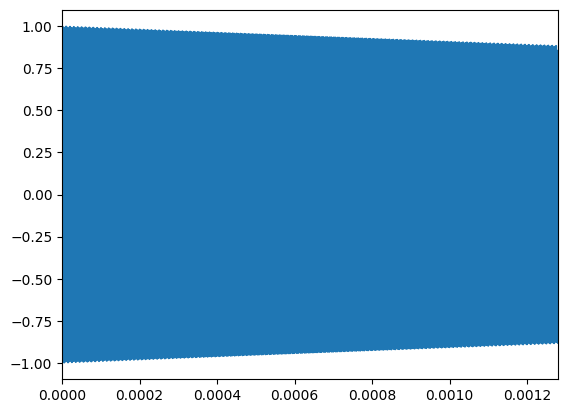

In [2]:
NSAMPLES = 4096
TONE = 901.5e6
LO = 901e6
SAMPLE_RATE = 3.2e6
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

sample_fq = 3.200105e6
OFFSET = np.pi/3
re = np.cos(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
im = np.sin(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
data = np.array([re, im]).T
data = np.expand_dims(data, axis=0)  # add block axis (with nblocks=1)

plt.figure()
plt.plot(t, tone_cos-re)
plt.xlim(t.min(), t.max())
plt.show()

In [3]:
def phase(real, imag, tone_cos, tone_sin):
    """
    Compute phase difference between data and tone
    """
    data_cos = real * tone_cos - imag * tone_sin  # real part (real*real - im*im)
    data_sin = real * tone_sin + imag * tone_cos  # imaginary (real*im + im*real)
    dphi = -np.arctan2(data_sin, data_cos) # phase difference in units of radians
    return dphi

In [4]:
data = data - np.mean(data, axis=1, keepdims=True)  # remove DC offset
real = data[0, :, 0]
imag = data[0, :, 1]
dphi = phase(real, imag, tone_cos, tone_sin)
dphi -= dphi[0]

# recover the ADC sample rate
den = omega * t - np.unwrap(dphi)
nonzero = den != 0
sample_ADC = np.mean(SAMPLE_RATE * omega * t[nonzero] / den[nonzero])
print(sample_ADC / sample_fq)  # how close we are to the true ADC sampling rate

0.9999999681248691


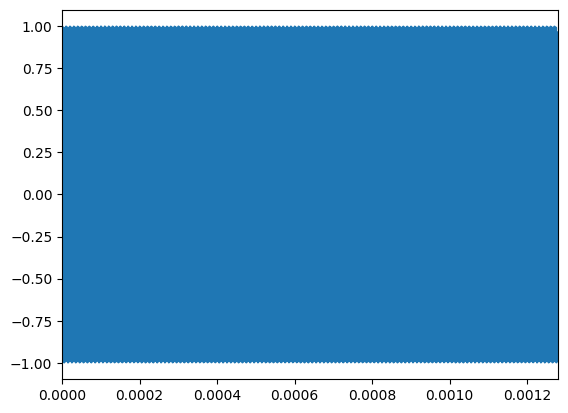

In [5]:
resamp_real, resamp_imag = resample(np.array([real, imag]), sample_ADC, SAMPLE_RATE)

plt.figure()
plt.plot(t, tone_cos - resamp_real)
plt.xlim(t.min(), t.max())
plt.show()

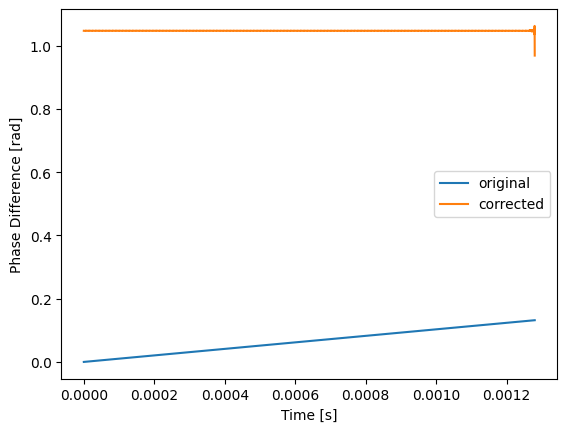

In [6]:
rs_cos = resamp_real * tone_cos - resamp_imag * tone_sin
rs_sin = resamp_real * tone_sin + resamp_imag * tone_cos
rs_dphi = np.arctan2(rs_sin, rs_cos)

plt.figure()
plt.plot(t, dphi, label="original")
plt.plot(t, rs_dphi, label="corrected")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.show()

## Real data

In [119]:
d = np.load("../data/data_0403.npz")
data = d["data"][1:, 0]
rs_data = d["rs_data"][1:]
dphi = d["dphi"][1:]
rs_dphi = d["rs_dphi"][1:]


NSAMPLES = d["nsamples"][()]
TONE = d["tone"][()]
LO = d["lo"][()]
SAMPLE_RATE = d["sample_rate"][()]
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

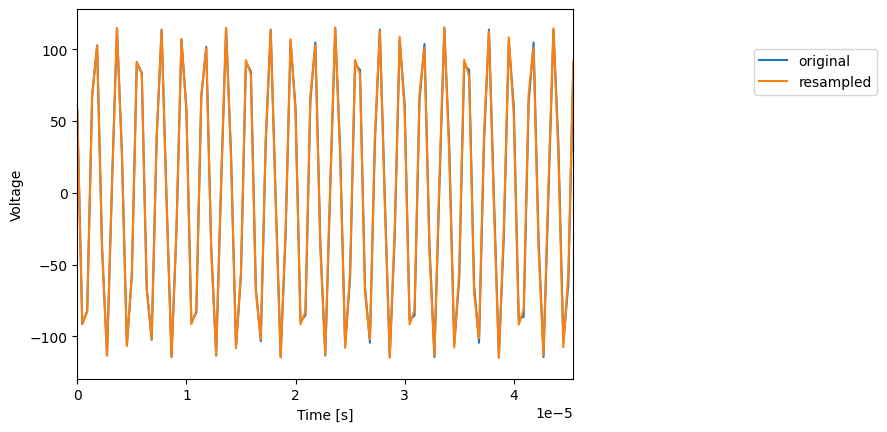

In [120]:
plt.figure()
plt.plot(t, data[0, :, 0], label="original")
plt.plot(t, rs_data[0, :, 0], label="resampled")
plt.ylabel("Voltage")
plt.xlabel("Time [s]")
plt.legend(bbox_to_anchor=[1.35, .75])
plt.xlim(t[0], t[100])
plt.show()

3 / 308
0.019378792488590424


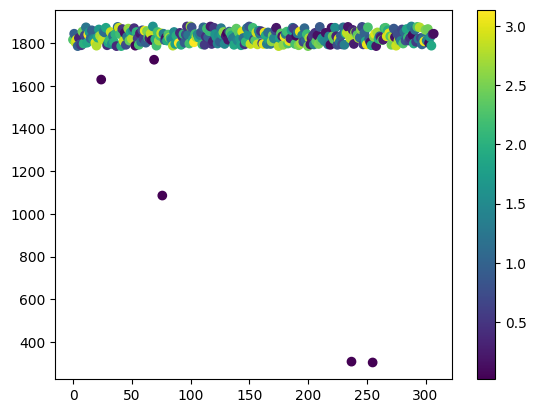

In [121]:
diff = np.abs(np.diff(np.unwrap(dphi), axis=1))
m = diff.max(axis=1)
argm = diff.argmax(axis=1)
ix = m.argsort()[0]
print(np.count_nonzero(m < 5*diff.mean(axis=1)), "/", len(data))
print(m[ix])

plt.figure()
plt.scatter(np.arange(len(data)), argm, c=m)
plt.colorbar()
plt.show()

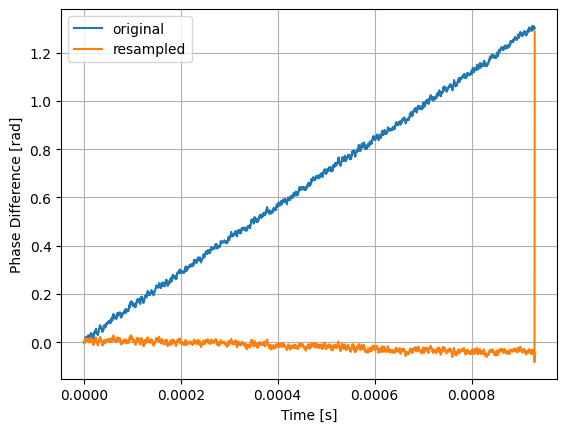

In [122]:
plt.figure()
plt.plot(t, dphi[ix], label="original")
plt.plot(t, rs_dphi[ix]-rs_dphi[ix, 0], label="resampled")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()
plt.show()

In [141]:
t_rep = np.repeat(t[None], len(data), axis=0)
den = omega * t_rep - np.unwrap(dphi)
sample_adc = np.nanmean((SAMPLE_RATE * omega * t_rep / den)[:1700], axis=1)
print(sample_adc.shape)

rs2 = np.empty_like(data)
dphi2 = np.empty_like(dphi) 

for i in range(len(data)):
    real = data[i, :, 0]
    imag = data[i, :, 1]
    rs2[i, :, 0] = resample(real, sample_adc[i], SAMPLE_RATE)
    rs2[i, :, 1] = resample(imag, sample_adc[i], SAMPLE_RATE)
    dphi2[i] = phase(rs2[i, :, 0], rs2[i, :, 1], tone_cos, tone_sin)


/tmp/ipykernel_49546/4107524242.py:3: RuntimeWarning: invalid value encountered in divide
  sample_adc = np.nanmean((SAMPLE_RATE * omega * t_rep / den)[:1700], axis=1)


(308,)


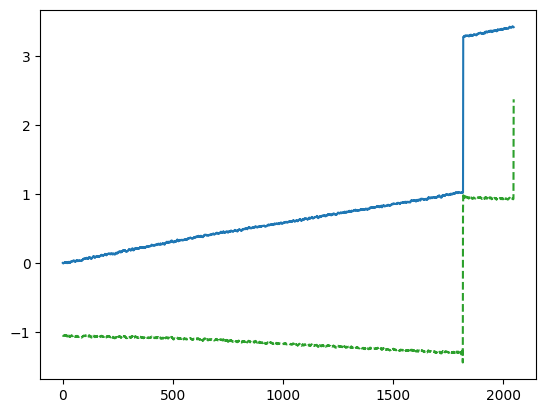

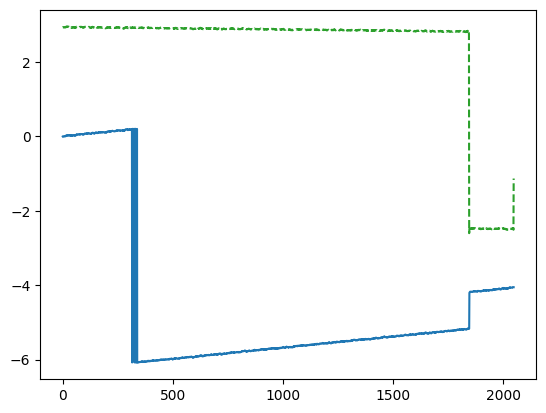

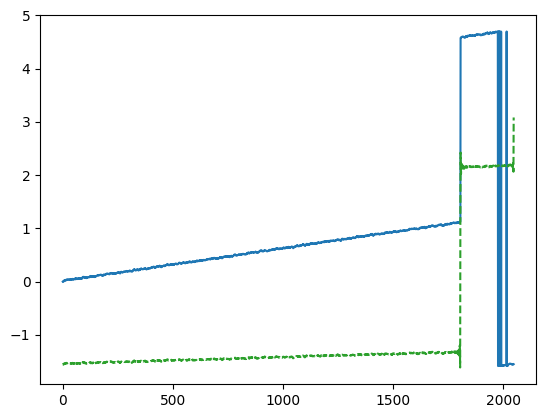

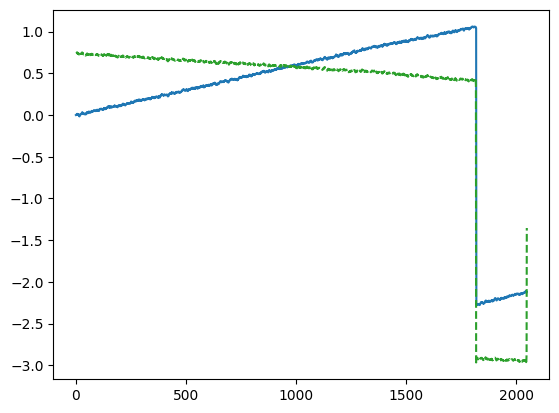

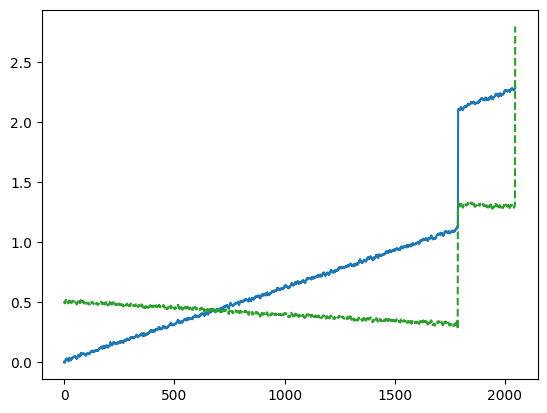

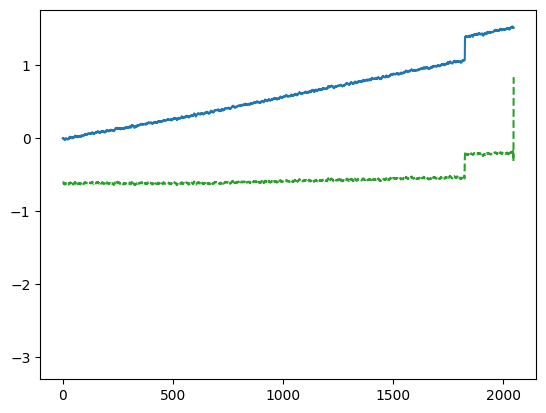

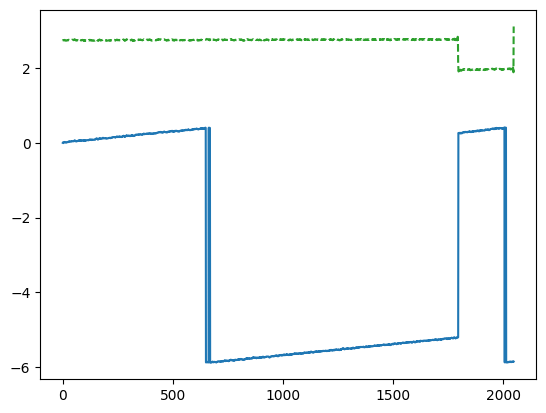

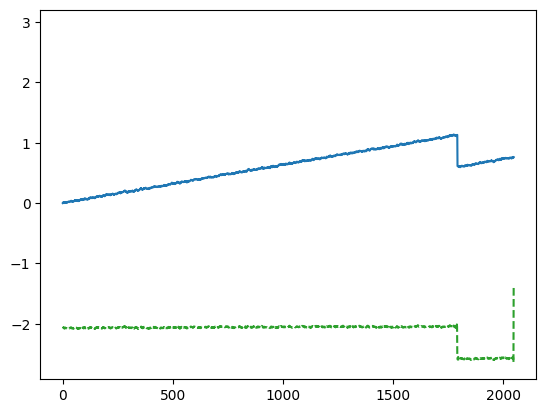

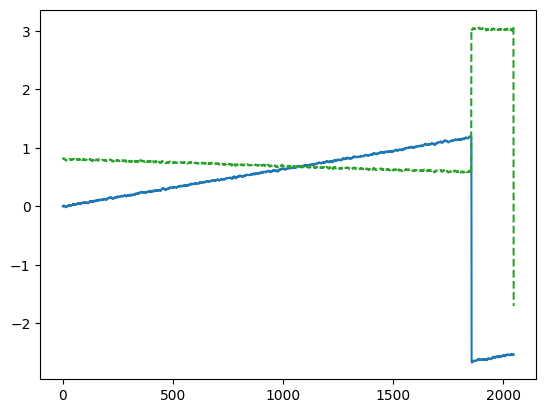

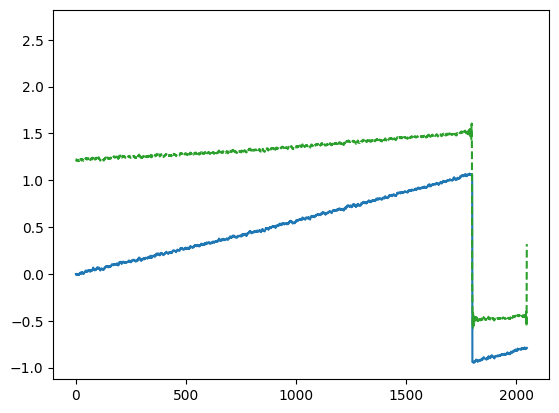

In [143]:
for i in range(10):
    plt.figure()
    plt.plot(dphi[i])
    plt.plot(rs_dphi[i])
    plt.plot(dphi2[i], ls="--")
    plt.show()

### Is it stable with time?

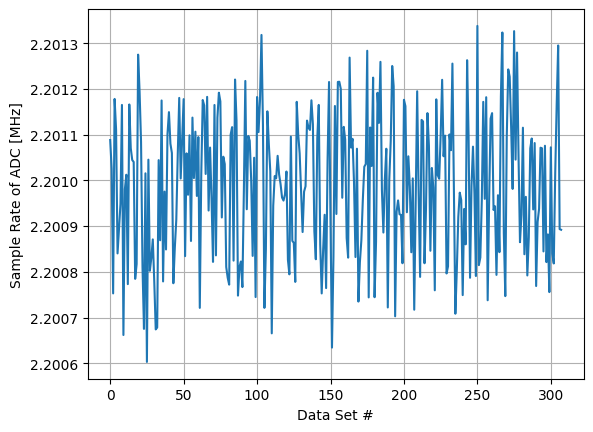

In [75]:
sr_adc = d["sample_adc"][1:]
plt.figure()
plt.plot(sr_adc / 1e6)
plt.ylabel("Sample Rate of ADC [MHz]")
plt.xlabel("Data Set #")
plt.grid()
plt.show()

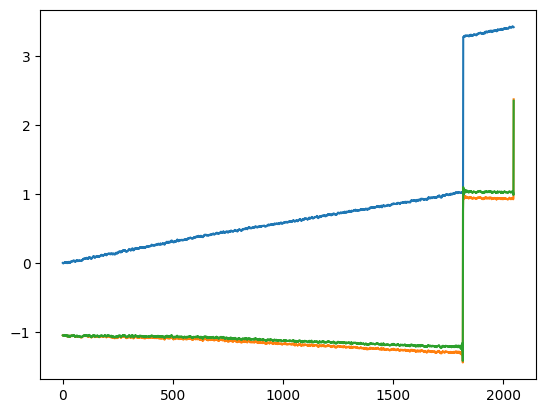

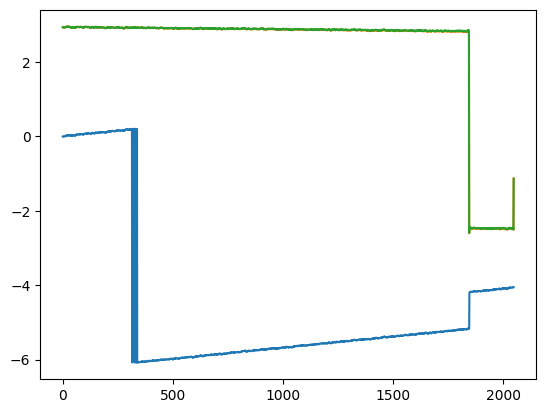

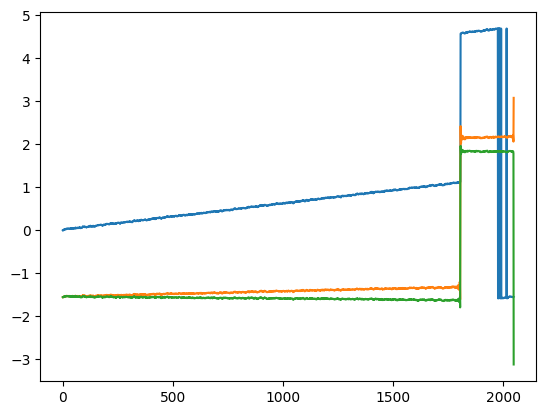

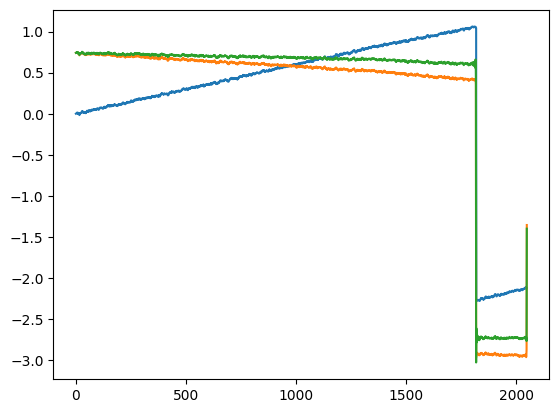

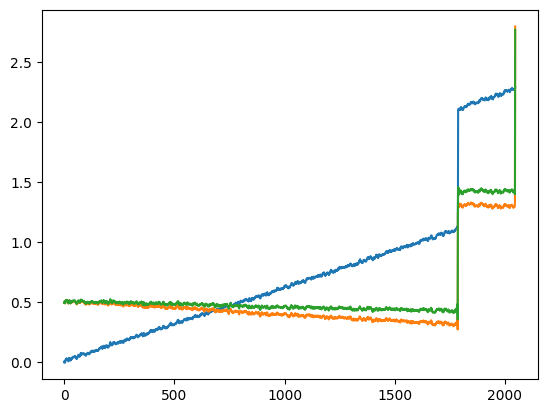

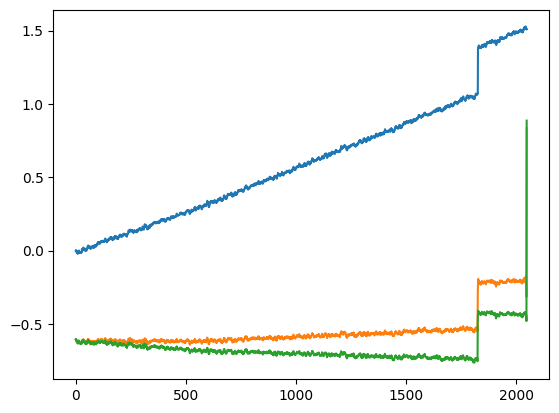

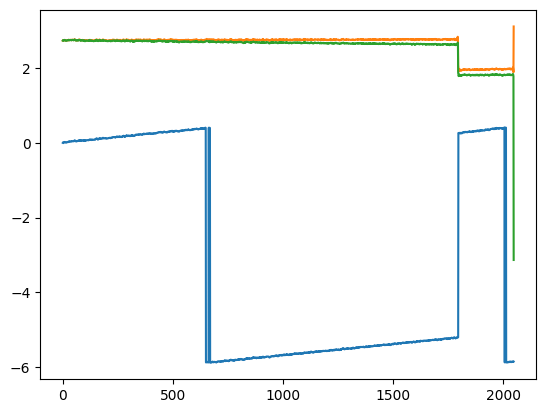

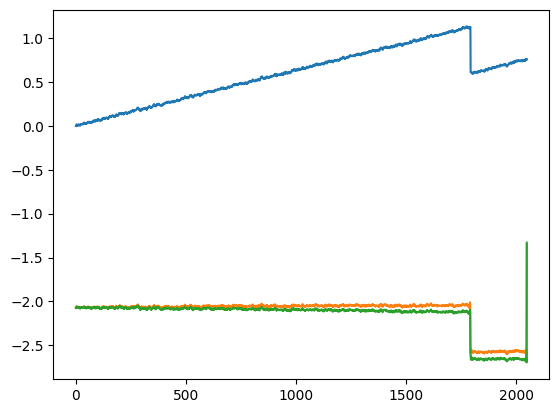

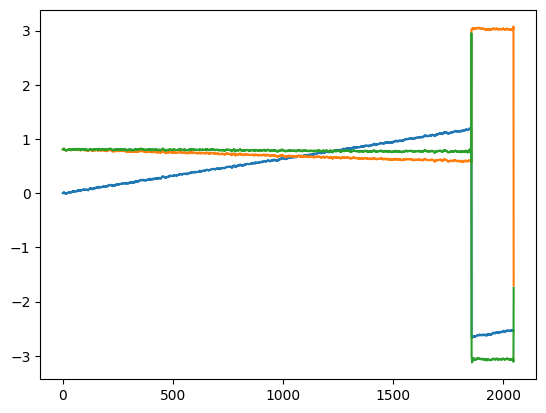

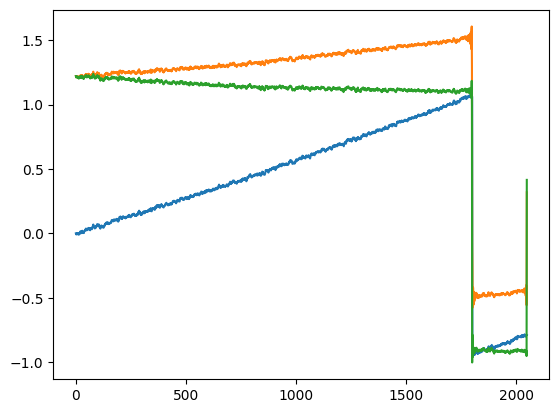

In [76]:
#f_in = sr_adc.mean()
f_in = sr_adc[ix]

resamp_real = resample(data[:, :, 0], f_in, SAMPLE_RATE)
resamp_imag = resample(data[:, :, 1], f_in, SAMPLE_RATE)
ph = phase(resamp_real, resamp_imag, tone_cos, tone_sin)
for i in range(10):
    plt.figure()
    plt.plot(dphi[i])
    plt.plot(rs_dphi[i])
    plt.plot(ph[i])
    plt.show()